In [16]:
# ============================================================================
# CONFIGURATION
# This cell contains all the settings a user needs to change.
# ============================================================================

# --- PATHS ---
# TODO: Update these paths to point to the two imputed data files you want to compare.
IMPUTATION_FILE_1 = "/users/aranpurdy/desktop/cfps/PCA/KNN/MOD_KNN_Imputed.xlsx"
IMPUTATION_FILE_2 = "/users/aranpurdy/desktop/cfps/PCA/RF/MOD_RF_Imputed.xlsx"

# The directory where the analysis plots and Excel summary will be saved.
OUTPUT_DIR = "/users/aranpurdy/desktop/GIT/CONCORDANCE"


# --- ANALYSIS PARAMETERS ---
# A short, descriptive name for each imputation method for use in plots and legends.
METHOD_1_NAME = "KNN"
METHOD_2_NAME = "RF"

# List of data pretreatment methods to apply and compare.
# Options: 'log', 'autoscale', 'pareto', 'log_auto', 'log_pareto'
PRETREATMENT_METHODS_TO_RUN = ['log', 'autoscale', 'pareto', 'log_auto', 'log_pareto']

# Number of Principal Components to calculate.
N_COMPONENTS_PCA = 5

METHOD_COLORS = {
    'log': '#E74C3C',         # Bright Red
    'autoscale': '#3498DB',   # Bright Blue
    'pareto': '#2ECC71',      # Bright Green
    'log_auto': '#F39C12',    # Orange
    'log_pareto': '#9B59B6'   # Purple
}

In [17]:
# ============================================================================
# SCRIPT LOGIC (Functions)
# This cell contains the core logic of the script.
# A user typically does not need to edit this cell.
# ============================================================================
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# --- Setup and Helper Functions ---
# ... (load_data, log_transform, autoscale, pareto_scale, apply_pretreatment, perform_pca are all correct) ...
warnings.filterwarnings('ignore')
plt.style.use('default')

def load_data(file_path):
    try:
        return pd.read_excel(file_path, index_col=0)
    except Exception as e:
        print(f"ERROR: Could not load data from {file_path}. Details: {e}")
        return None

def log_transform(X):
    return np.log1p(X)

def autoscale(X):
    return StandardScaler().fit_transform(X)

def pareto_scale(X):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0, ddof=1)
    X_std[X_std == 0] = 1
    return (X - X_mean) / np.sqrt(X_std)

def apply_pretreatment(data, method):
    if method == 'log_auto':
        return autoscale(log_transform(data))
    elif method == 'log_pareto':
        return pareto_scale(log_transform(data))
    pretreatments = {'log': log_transform, 'autoscale': autoscale, 'pareto': pareto_scale}
    return pretreatments.get(method, lambda x: x)(data)

def perform_pca(data, n_components):
    max_components = min(data.shape)
    if n_components > max_components:
        n_components = max_components
    pca = PCA(n_components=n_components)
    scores = pca.fit_transform(data)
    loadings = pca.components_.T
    pc_names = [f'PC{i+1}' for i in range(n_components)]
    scores_df = pd.DataFrame(scores, index=data.index, columns=pc_names)
    loadings_df = pd.DataFrame(loadings, index=data.columns, columns=pc_names)
    return scores_df, loadings_df, pca

# UPDATED FUNCTION SIGNATURE
def create_combined_figure(results_dict, method1_name, method2_name, output_dir, color_map):
    """Create a single, comprehensive figure with all plots arranged in a grid."""
    print("Generating comprehensive summary plot...")
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(3, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    # PC1 Scores Concordance (UPDATED to use color_map)
    for method, data in results_dict.items():
        scores1 = data[method1_name]['scores']['PC1']
        scores2 = data[method2_name]['scores']['PC1']
        r, _ = pearsonr(scores1, scores2)
        ax1.scatter(scores1, scores2, label=f'{method} (R²={r**2:.2f})', color=color_map.get(method), alpha=0.7)
    lims1 = [min(ax1.get_xlim()[0], ax1.get_ylim()[0]), max(ax1.get_xlim()[1], ax1.get_ylim()[1])]
    ax1.plot(lims1, lims1, 'k--', alpha=0.5)
    ax1.set_title('PC1 Scores Concordance'); ax1.set_xlabel(f'PC1 Scores ({method1_name})'); ax1.set_ylabel(f'PC1 Scores ({method2_name})'); ax1.legend()

    # PC1 Loadings Concordance (UPDATED to use color_map)
    for method, data in results_dict.items():
        loadings1 = data[method1_name]['loadings']['PC1']
        loadings2 = data[method2_name]['loadings']['PC1']
        if pearsonr(loadings1, loadings2)[0] < 0: loadings2 = -loadings2
        r, _ = pearsonr(loadings1, loadings2)
        ax2.scatter(loadings1, loadings2, label=f'{method} (R²={r**2:.2f})', color=color_map.get(method), alpha=0.7)
    lims2 = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]), max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
    ax2.plot(lims2, lims2, 'k--', alpha=0.5)
    ax2.set_title('PC1 Loadings Concordance (Sign-Corrected)'); ax2.set_xlabel(f'PC1 Loadings ({method1_name})'); ax2.set_ylabel(f'PC1 Loadings ({method2_name})'); ax2.legend()
    
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    plot_data = []
    for method, data in results_dict.items():
        plot_data.append(pd.DataFrame({'Pretreatment': method, 'PC1_Score': data[method1_name]['scores']['PC1']}))
    # (UPDATED to use color_map)
    sns.boxplot(data=pd.concat(plot_data), x='Pretreatment', y='PC1_Score', ax=ax3, palette=color_map)
    ax3.set_title(f'PC1 Score Distribution ({method1_name})'); ax3.tick_params(axis='x', rotation=45)
    
    plot_data = []
    for method, data in results_dict.items():
        plot_data.append(pd.DataFrame({'Pretreatment': method, 'PC1_Score': data[method2_name]['scores']['PC1']}))
    # (UPDATED to use color_map)
    sns.boxplot(data=pd.concat(plot_data), x='Pretreatment', y='PC1_Score', ax=ax4, palette=color_map)
    ax4.set_title(f'PC1 Score Distribution ({method2_name})'); ax4.tick_params(axis='x', rotation=45)

    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    
    var_data = []
    for method, data in results_dict.items():
        var1 = data[method1_name]['pca'].explained_variance_ratio_ * 100
        var2 = data[method2_name]['pca'].explained_variance_ratio_ * 100
        for i in range(len(var1)): var_data.append({'Pretreatment': method, 'Imputation': method1_name, 'PC': f'PC{i+1}', 'Variance': var1[i]})
        for i in range(len(var2)): var_data.append({'Pretreatment': method, 'Imputation': method2_name, 'PC': f'PC{i+1}', 'Variance': var2[i]})
    var_df = pd.DataFrame(var_data)
    # (UPDATED to use color_map)
    sns.lineplot(data=var_df, x='PC', y='Variance', hue='Pretreatment', style='Imputation', marker='o', ax=ax5, palette=color_map)
    ax5.set_title('Variance Explained per Principal Component')

    methods_plot = list(results_dict.keys())
    pcs_to_plot = ['PC1', 'PC2', 'PC3']
    r2_data = {pc: [] for pc in pcs_to_plot}; var_data_bar = {pc: [] for pc in pcs_to_plot}
    for method in methods_plot:
        for i, pc in enumerate(pcs_to_plot):
            if i < results_dict[method][method1_name]['pca'].n_components_:
                scores1 = results_dict[method][method1_name]['scores'][pc]; scores2 = results_dict[method][method2_name]['scores'][pc]
                r = pearsonr(scores1, scores2)[0]
                r2_data[pc].append(r ** 2)
                var1 = results_dict[method][method1_name]['pca'].explained_variance_ratio_[i] * 100; var2 = results_dict[method][method2_name]['pca'].explained_variance_ratio_[i] * 100
                var_data_bar[pc].append((var1 + var2) / 2)
            else:
                r2_data[pc].append(0); var_data_bar[pc].append(0)
    
    x = np.arange(len(methods_plot)); width = 0.25; pc_colors = ['#3498DB', '#E74C3C', '#2ECC71']
    for i, pc in enumerate(pcs_to_plot):
        bars = ax6.bar(x + i*width, r2_data[pc], width, label=pc, color=pc_colors[i], alpha=0.8, edgecolor='black')
        for bar, var in zip(bars, var_data_bar[pc]):
            ax6.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{var:.1f}%', ha='center', va='bottom', fontsize=7, weight='bold')
    
    ax6.set_ylabel('Concordance (R²)')
    ax6.set_title('PC Score Concordance (Avg. Var. Explained % shown)')
    ax6.set_xticks(x + width)
    ax6.set_xticklabels(methods_plot, rotation=45, ha="right")
    ax6.legend(title='PC'); ax6.set_ylim(0, 1.15)
    
    fig.tight_layout()
    output_path = os.path.join(output_dir, 'PCA_Combined_Analysis.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Combined analysis plot saved to: {output_path}")

def create_excel_output(results, method1_name, method2_name, output_dir):
    output_path = os.path.join(output_dir, 'PCA_Concordance_Results.xlsx')
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        summary_data = []
        for method, data in results.items():
            max_pcs = min(len(data[method1_name]['scores'].columns), len(data[method2_name]['scores'].columns))
            for i in range(max_pcs):
                pc = f'PC{i+1}'; scores1 = data[method1_name]['scores'][pc]; scores2 = data[method2_name]['scores'][pc]; r_scores = pearsonr(scores1, scores2)[0]
                loadings1 = data[method1_name]['loadings'][pc]; loadings2 = data[method2_name]['loadings'][pc]
                if pearsonr(loadings1, loadings2)[0] < 0: loadings2 = -loadings2
                r_loadings = pearsonr(loadings1, loadings2)[0]
                summary_data.append({
                    'Pretreatment': method, 'PC': pc,
                    f'{method1_name}_Variance_Explained': data[method1_name]['pca'].explained_variance_ratio_[i],
                    f'{method2_name}_Variance_Explained': data[method2_name]['pca'].explained_variance_ratio_[i],
                    'Scores_R2': r_scores**2, 'Loadings_R2_SignCorrected': r_loadings**2
                })
        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary_Stats', index=False)
    print(f"Excel summary saved to: {output_path}")

# UPDATED FUNCTION SIGNATURE
def run_concordance_analysis(file1, file2, name1, name2, pretreatments, n_comps, output_dir, color_map):
    """Orchestrates the entire PCA concordance analysis."""
    print("--- Starting PCA Concordance Analysis ---")
    os.makedirs(output_dir, exist_ok=True)
    
    data1 = load_data(file1)
    data2 = load_data(file2)
    if data1 is None or data2 is None: return

    common_features = data1.index.intersection(data2.index)
    common_samples = data1.columns.intersection(data2.columns)
    data1 = data1.loc[common_features, common_samples].T
    data2 = data2.loc[common_features, common_samples].T
    print(f"Data aligned. Shape: {data1.shape}")

    results = {}
    for method in pretreatments:
        print(f"Processing pretreatment: {method}...")
        processed1_df = pd.DataFrame(apply_pretreatment(data1.copy(), method), index=data1.index, columns=data1.columns)
        processed2_df = pd.DataFrame(apply_pretreatment(data2.copy(), method), index=data2.index, columns=data2.columns)
        
        scores1, loadings1, pca1 = perform_pca(processed1_df, n_components=n_comps)
        scores2, loadings2, pca2 = perform_pca(processed2_df, n_components=n_comps)
        
        results[method] = {
            name1: {'scores': scores1, 'loadings': loadings1, 'pca': pca1},
            name2: {'scores': scores2, 'loadings': loadings2, 'pca': pca2}
        }
    
    if not results:
        print("Analysis failed to produce results.")
        return
        
    # UPDATED FUNCTION CALL
    create_combined_figure(results, name1, name2, output_dir, color_map)
    create_excel_output(results, name1, name2, output_dir)
    print("\n--- Pipeline Finished ---")

--- Starting PCA Concordance Analysis ---
Data aligned. Shape: (50, 115)
Processing pretreatment: log...
Processing pretreatment: autoscale...
Processing pretreatment: pareto...
Processing pretreatment: log_auto...
Processing pretreatment: log_pareto...
Generating comprehensive summary plot...


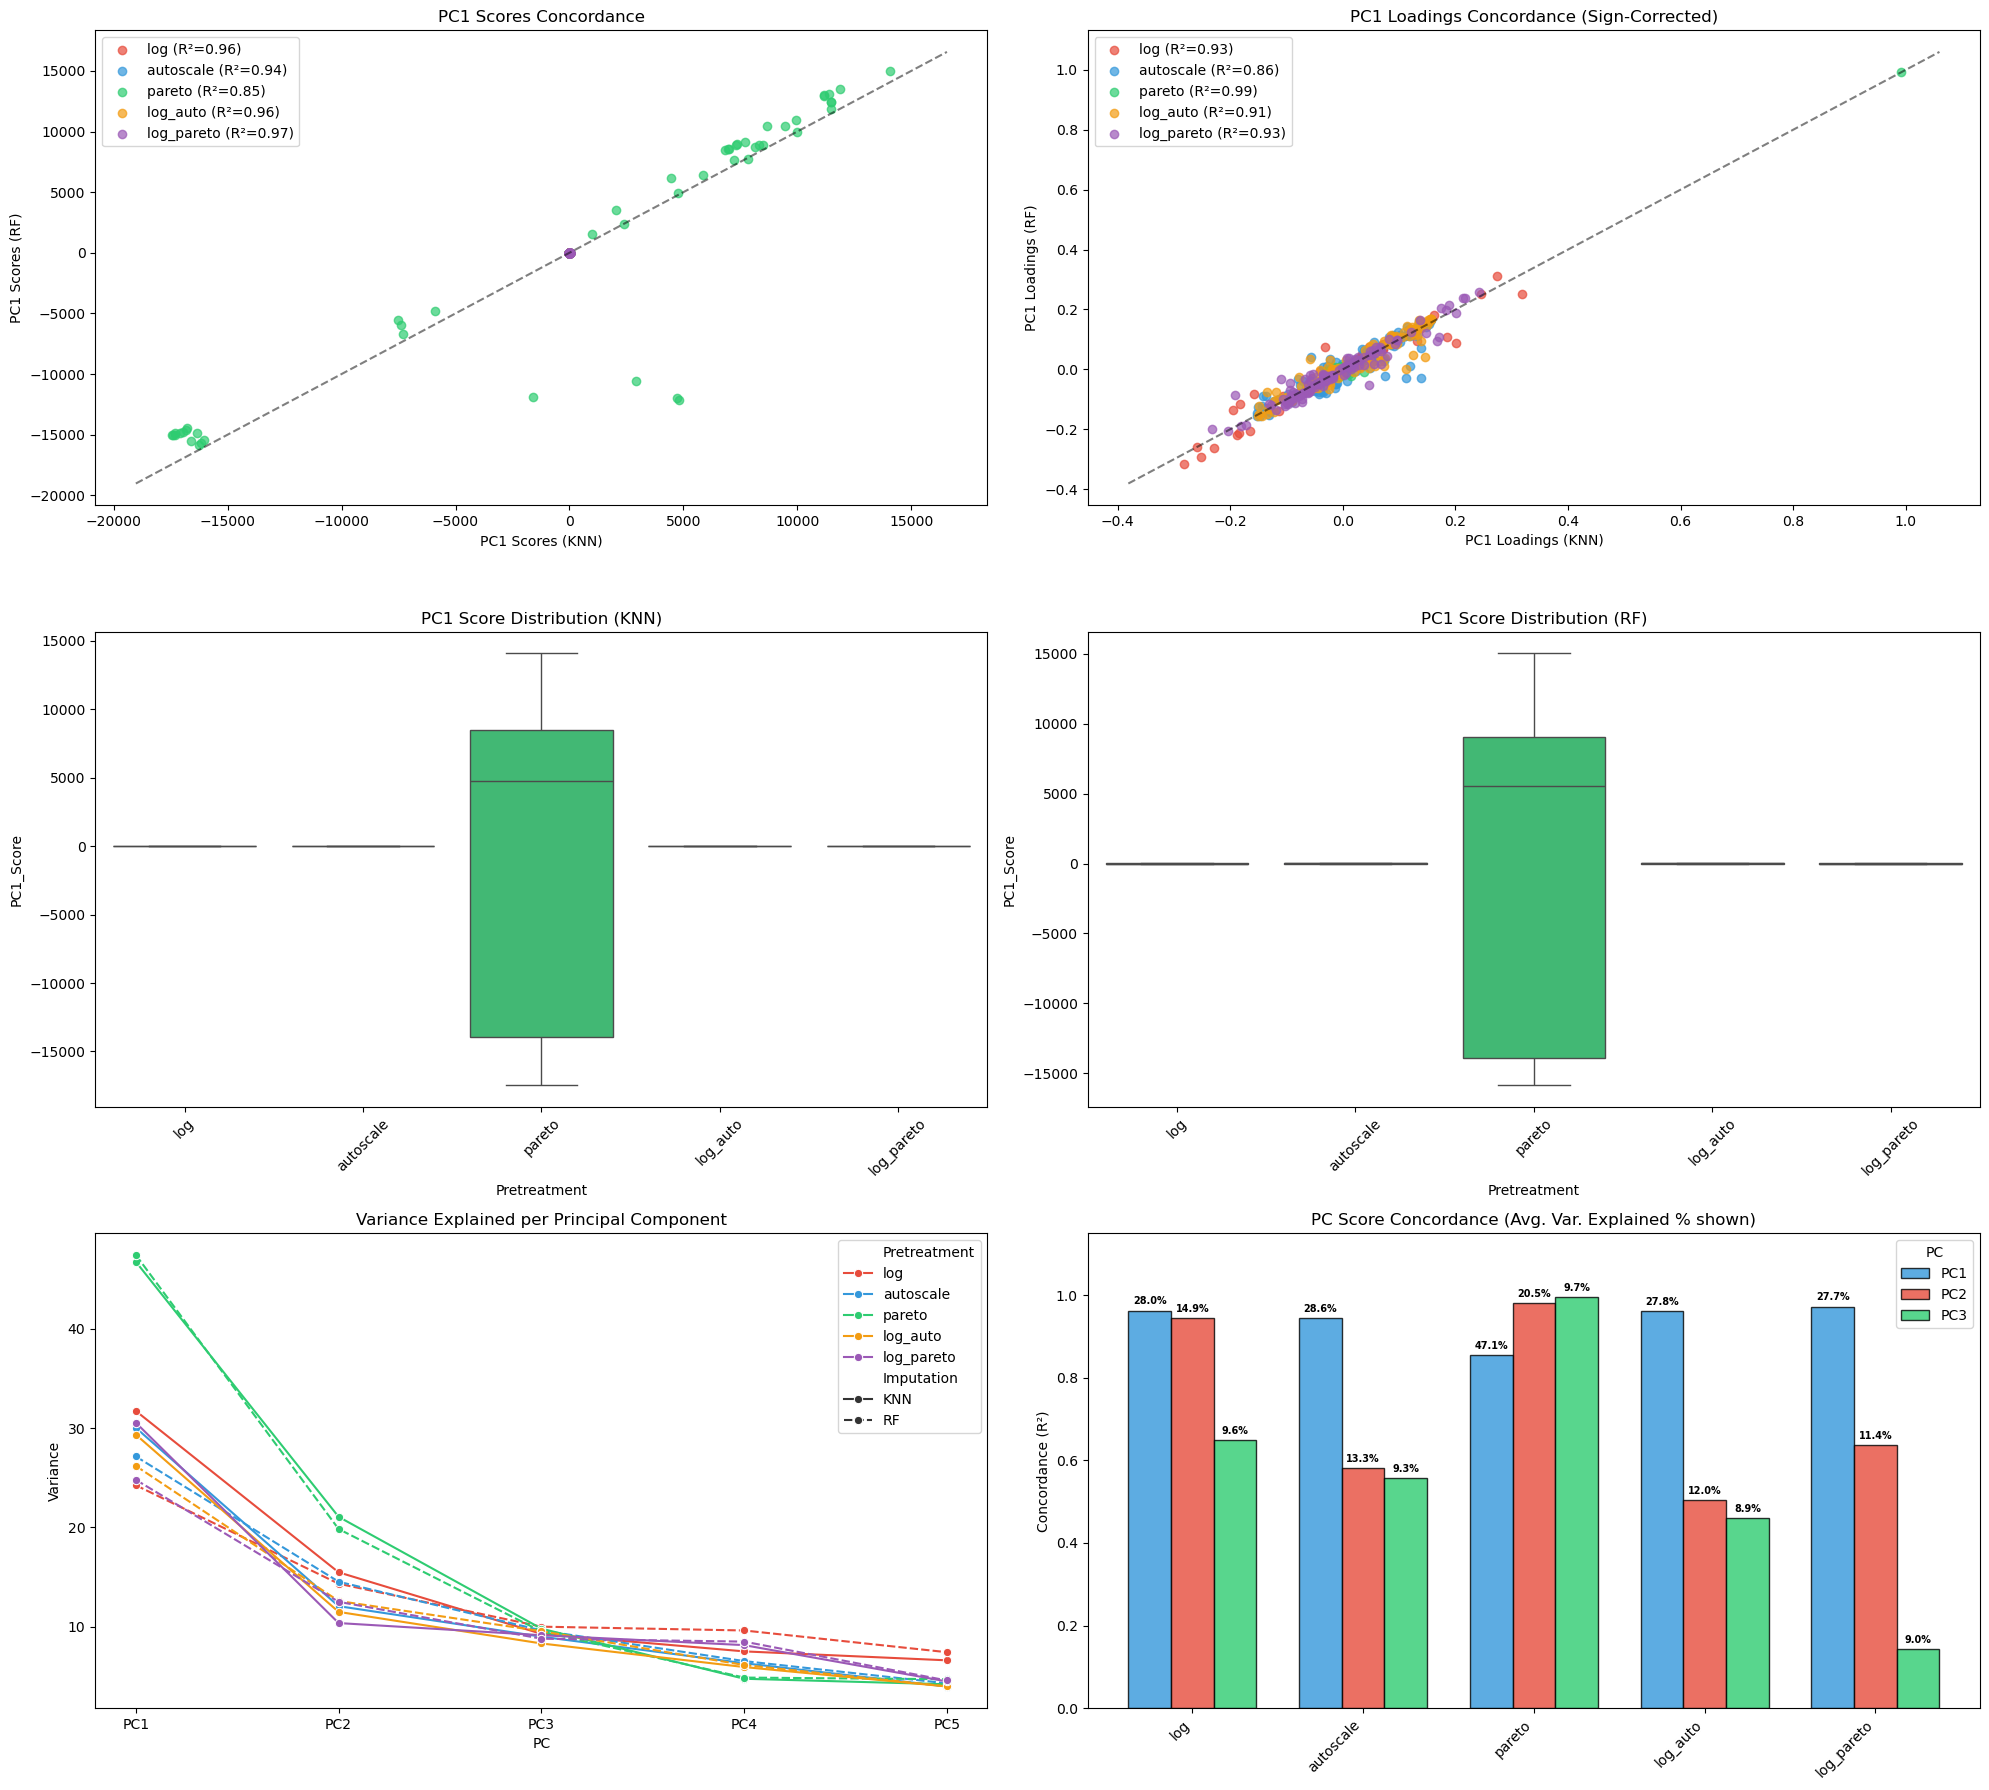

Combined analysis plot saved to: /users/aranpurdy/desktop/GIT/CONCORDANCE/PCA_Combined_Analysis.png
Excel summary saved to: /users/aranpurdy/desktop/GIT/CONCORDANCE/PCA_Concordance_Results.xlsx

--- Pipeline Finished ---


In [18]:
# ============================================================================
# EXECUTION
# This cell calls the main function using the variables from the Configuration cell.
# ============================================================================

run_concordance_analysis(
    file1=IMPUTATION_FILE_1,
    file2=IMPUTATION_FILE_2,
    name1=METHOD_1_NAME,
    name2=METHOD_2_NAME,
    pretreatments=PRETREATMENT_METHODS_TO_RUN,
    n_comps=N_COMPONENTS_PCA,
    output_dir=OUTPUT_DIR,
    color_map=METHOD_COLORS  # Pass the color dictionary as an argument
)